# Pruning decision trees and handling missing data 

Author: Jack Dawe

Starting point article: https://www.jmlr.org/papers/v11/ding10a.html which will be referred to as Ding et al. (2010)

# Introduction

Decision trees are not new, but they are still widely used today. They are used to solve many machine learning problems, and can be combined to make powerful algorithms such as random forest and boosting. In this notebook, I want to explore some aspects around decision trees that we have not seen much in class: how to fight overfitting and how to handle incomplete datasets.

Ding et al. (2010) studies 6 different ways to handle missing data on many different missingness patterns, leading to pages of exhaustive results (that I coudln't bring myself to all read). For your sanity (and mine), I will not talk about those, but rather give you an overview of the methods and algorithms mentioned in the article.  

# Decision trees

Decision trees are a non-parametric supervised learning method used for classification and regression. They are very easy to understand and to visualise and require very little data preparation. They are also very convenient when you have incomplete datasets as some methods exist to overcome this problem without having to discard the datapoint with missing values. 

However, decision trees are easily subject to overfitting and small variation in the data can lead to a completely different result. 

(Source: scikit learn)

## Decision tree building

Before digging into the heart of the subject, I would like to describe the two most popular algorithms used to build trees. 

### c4.5

Probabilistic split is a method that is built in the c4.5 decision tree building algorithm (Quinlan, 1993). c4.5 is the successor of ID3 which is the algorithm that we saw in class. As a brief reminder, ID3 choses the feature on which to perform a split by comparing the entropy gain and keeping the feature with the maximum value. 

Sources: Quinlan (1993), http://inferate.blogspot.com/2015/06/c45-decision-trees-with-missing-data.html

Lets imagine we want to predict from weather data whether or not we should go and play tennis. I load below a small dataset that we can use as an example. 

In [1]:
import pandas as pd
import numpy as np

def log2(x):
    return np.log(x)/np.log(2)

df = pd.read_csv('data/tennis.csv',sep=';')
df

,Day,Outlook,Temperature,Humidity,Wind,PlayTennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
9,D10,Rain,Mild,Normal,Weak,Yes


As I said, c4.5 enhances the older algorithm ID3. So to compare how, I will quickly remind you the formulas of the ID3 split criterion and implement them. As you may remember from class, we want to find the feature that allows us to split our data in a way that we maximize the entropy gained from this split. 

Lets define first the entropy of a dataset $S$: 

$$ H(S) = -\sum_{i=1}^{C} p(S,i)\log_2(p(S,i)) $$

where $C$ is the number of classes and $p(S,i)$ the proportion of the class $i$ in the set $S$. 

The entropy gain from splitting across a feature $A$ in the set $S$ is defined as follow:

$$ G(S,A) = H(S) - \sum_{v \in A}^{} \frac{|S_v|}{|S|}H(S_v) $$

where $S_v$ represents a subset of $S$ containing all the occurences of the value $v$.

Lets try on our dataset ! In the cell below I compute the entropy gain for each of my features:

In [2]:
def entropy(S):
    p = len(S.loc[S['PlayTennis']=='Yes'])/len(S)
    if (p*(1-p) == 0):
        return 0
    return -(p*log2(p) + (1-p)*log2(1-p)) #Quite easy to compute since we only have 2 classes

def entropy_gain(S,feature):
    values_taken = S[feature].unique()
    value_counts = S[feature].value_counts()
    n = len(S)
    entropy_loss = 0
    for i in range(0,len(values_taken)):
        Sv = S.loc[S[feature] == values_taken[i]]
        entropy_loss+=(value_counts[values_taken[i]]/n)*entropy(Sv)
    return entropy(S)-entropy_loss

print("Entropy of the whole dataset: "+str(round(entropy(df),3)))
print("\nEntropy Gain:\n")
for feature in df.columns[1:-1]:
    print(feature+" :",round(entropy_gain(df,feature),3))

Entropy of the whole dataset: 0.94

Entropy Gain:

Outlook : 0.247
Temperature : 0.029
Humidity : 0.152
Wind : 0.048


Given these results, the first split will be done using the Outlook feature ! 

The problem of this criterion is that features with more possible outcomes tend to be favored. We can see that by adding a new outcome in the $Outcast$ feature:

In [3]:
df2 = df.copy()
df2['Outlook'][4] = 'Snow'
print(df2.head(5))

print("\nEntropy of the whole dataset: "+str(round(entropy(df2),3)))
print("\nEntropy Gain:\n")
for feature in df2.columns[1:-1]:
    print(feature+" :",round(entropy_gain(df2,feature),3))


  Day   Outlook Temperature Humidity    Wind PlayTennis
0  D1     Sunny         Hot     High    Weak         No
1  D2     Sunny         Hot     High  Strong         No
2  D3  Overcast         Hot     High    Weak        Yes
3  D4      Rain        Mild     High    Weak        Yes
4  D5      Snow        Cool   Normal    Weak        Yes

Entropy of the whole dataset: 0.94

Entropy Gain:

Outlook : 0.308
Temperature : 0.029
Humidity : 0.152
Wind : 0.048


The entropy gain of Outlook as increased quite significantly. 

c4.5 uses a new splitting criterion called the **gain ratio criterion** defined as followed: 

$$ G_r(S,A) = \frac{G(S,A)}{Split(S,A)}$$

where

$$ Split(S,A) = -\sum_{v \in A}^{} \frac{|S_v|}{|S|}\log_2(\frac{|S_v|}{|S|}) $$

$Split(S,A)$ penalises a feature for having many individual values. It is maximal if a feature only has individual values. We can see its immediate effect on $Outlook$, putting it very close to being put behing $Humidity$. 

In [4]:
def gain_ratio(S,feature):
    n = len(S)
    values_taken = S[feature].unique()
    value_counts = S[feature].value_counts()
    si = 0
    for value in values_taken:
        p = len(S.loc[S[feature] == value])/n
        si -= p*log2(p)
    return(entropy_gain(S,feature)/si)

print("Entropy Gain Ratio:\n")
for feature in df.columns[1:-1]:
    print(feature+" :",round(gain_ratio(df,feature),3))
    

Entropy Gain Ratio:

Outlook : 0.156
Temperature : 0.019
Humidity : 0.152
Wind : 0.049


**Sources**: Quinlan (1993) and http://inferate.blogspot.com/2015/05/building-id3-decision-tree-by-hand.html

### Classification And Regression Trees (CART)

CART is a decision tree building algorithm that is very close to 4.5 in principle. It only uses binary splitting and uses Gini Impurity as splitting criterion: 

$$ I_G(S) = 1 - \sum_{i=1}^{C} p(S,i)^2 $$

CART has many advantages over c4.5, such as supporting boosting and using post-pruning to avoid overfitting. 

It has been very difficult to find good sources that present good examples of how CART works, so I will not go deeper in the explanations. 

# Handling missing data

It is not uncommon to receive datasets that are incomplete. Sometimes, you can just discard every lines with N/A values with one line of code. But by doing so, you are losing data that can be potentially very helpful for your model. And what do you do if your test set (supposed to be representative of the data your algorithm will encounter in production) contains missing values? Most algorithms that we know do not do well with N/As, but decision trees can actually train and infere with incomplete data. 

## Missingness Patterns

Before diving into these methods, I will briefly introduce you to three common missingness patterns. I will not go into alot of detail, but it is important to know that it exists. Indeed, it is a very good practice to identify the missingness pattern of your data before chosing the way of dealing with it. 

### Missing Completely At Random (MCAR)

There is no relationship between the missingness of the data and any values, observed or missing. Missing values appear randomly in the dataset. It is a case that is rather rare in reality. 

### Missing At Random (MAR)

There is a systemanic relationship between the tendancy of a value to be missing and the observed data (and not the missing data). This means that you can fully understand the missingness mechanism of a feature using features from which you have complete information. 

For example, if you imagine a dataset where each line contains information about someone (age, weight, earnings, and so on). If women are less likely to give their weight than men, then the 'weight' feature follows a MAR pattern.  

### Not Missing At Random (NMAR)

There is a relationship between the tendancy of a value to be missing and its values. This means that the value of the variable that's missing is related to the reason it's missing. 

In the previous dataset, people with low earnings might be less likely to share their earnings out of shame. 

Sources : https://www.theanalysisfactor.com/missing-data-mechanism/ and Wikipedia

To help with the comprehension of the different methods described below, I will two toy datasets: 
- the "Play tennis" dataset from which I have randomly removed some values (MCAR pattern !)
- a simple dataset with one feature following a $N(1,2)$ distribution and filled with missing values (50%)

In [5]:
# Dataset 1

df_missing = pd.read_csv('data/tennis_missing.csv',sep=';')
df_missing

,Day,Outlook,Temperature,Humidity,Wind,PlayTennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,?,Hot,High,Strong,No
2,D3,?,?,High,?,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,?,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,?,Mild,High,?,No
8,D9,?,Cool,Normal,Weak,Yes
9,D10,?,?,Normal,?,Yes


In [6]:
# Dataset 2

import matplotlib.pyplot as plt
complete_data = np.random.normal(1,2,10000)
missing_index = np.random.randint(0,10000,5000)
complete_data_df = pd.DataFrame(complete_data,columns=["value"])
missing_data_df = pd.DataFrame(complete_data,columns=["value"])
missing_data_df["value"][missing_index] = '?'
missing_data_df.head(12)

,value
0,0.607472
1,0.391712
2,3.21758
3,?
4,?
5,-3.87814
6,?
7,?
8,?
9,-0.908887


## Preprocessing methods for missing data

Preprocessing methods are incredibly popular methods because they are very fast and easy to implement. They are rather destructive though, so probably hard to use on datasets that are highly incomplete

### Complete Case

Complete Case consists in deleting each observation that contains any missing value in the training set. It is an easy way to deal with missing data, but you way lose some information depending on the amount of data that is discarded. This method is not applicable if your test set contains missing data (you can't discard your test set !!!)

### Complete Variable

All features that contain missing data are deleted. This obviously is quite a limited method, but can be useful if you have datasets with some features having the majority of the missing values (for example, if people don't like to share their drug consumption, just discard the column). Complete variable can be used on the test set, as you are free to chose the features you want to use to make your prediction. 

### Data imputation 

This method is very popular for numerical data (it is the best way for dealing with missing data with scikit learn so far). All you have to do is replace the missing values with the mean/median/mode of your feature. While this is very easy to implement, it totally changes the statistical nature of your data. Using histograms becomes impossible and the variance of your data is underestimated. 

In Ding et al. (2010)'s work, Mean imputation is used for continuous data and mode imputation for discrete data. 

Source: https://medium.com/@ODSC/data-imputation-beyond-mean-median-and-mode-6c798f3212e3

Lets visualise the effect of mean imputation on our toy dataset 2:

The missing values with be replaced by 0.9606

Variance of the complete data: 3.9958
Variance of the imputed incomplete data: 4.0013


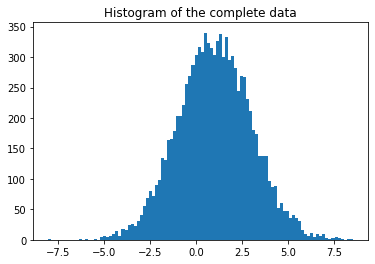

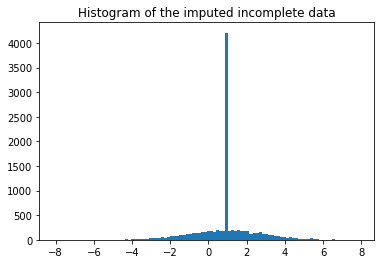

In [7]:
mean_imputation_df = missing_data_df.copy()

mean = round(float(mean_imputation_df.loc[missing_data_df['value']!='?'].mean()),4)
print("The missing values with be replaced by "+str(mean))
mean_imputation_df["value"][missing_index] = mean
variance = round(float(mean_imputation_df.loc[missing_data_df['value']!='?'].var()),4)


print("\nVariance of the complete data: "+str(round(complete_data.var(),4)))
print("Variance of the imputed incomplete data: "+str(variance))

plt.hist(complete_data,bins=100)
plt.title("Histogram of the complete data")
plt.show()
plt.hist(mean_imputation_df['value'].values,bins=100)
plt.title("Histogram of the imputed incomplete data")
plt.show()

### Separate Class

As indicated in its name, this method treats missing data as a fixed value of the feature for which the data is missing. 

#### Categorical features

For categorical features, missing values are replaced with the value "Missing":

In [8]:
df_categorical = df_missing.replace("?","Missing")
df_categorical

,Day,Outlook,Temperature,Humidity,Wind,PlayTennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Missing,Hot,High,Strong,No
2,D3,Missing,Missing,High,Missing,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Missing,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Missing,Mild,High,Missing,No
8,D9,Missing,Cool,Normal,Weak,Yes
9,D10,Missing,Missing,Normal,Missing,Yes


#### Numerical features

The missing values are replaced by a value that is outside the range of values of the feature. By putting a high value for the missing values, the decision tree will rapidly separate the missing values from the other values while training. 

In [9]:
df_numerical = missing_data_df.replace("?",100)
df_numerical

,value
0,0.607472
1,0.391712
2,3.217584
3,100.000000
4,100.000000
...,...
9995,3.115872
9996,100.000000
9997,3.463042
9998,1.469289


Separate class for categorical data suffers from the same disadvantanges from data imputation method. 

Source: Ding et al.(2013)

## Built-in methods

c4.5 and CART each come with their own built-in method to deal with incomplete datasets

## c4.5: Probabilistic Split 

c4.5 can handle missing data during training and inference phase. 

### Training

c4.5's way of dealing with missing data while training if very simple. The gain ratio is weighted by the proportion of available data for the given feature: 

$$ G_{r,m}(S,A) = \frac{|S|-|S_{M,A}|}{|S|}x\frac{G(S,A)}{Split(S,A)}$$

where $|S_{M,A}|$ is the amount of missing data for the feature $A$

But how do we compute $H(S)$, $Split(S,A)$ and $G(S,A)$  with a dataset with missing values? 

To compute the entropy and the entropy gain with missing data $H_m(S,A)$ and $G_m(S,A)$, we only use the datapoints for which we have a value for the feature $A$: 

$$ H_m(S,A) = -\sum_{i=1}^{C} p_m(S,A,i)\log_2(p_m(S,A,i)) $$

$$ G_m(S,A) = H_m(S,A) - \sum_{\substack{v \in A \\ v \ne?}}^{} \frac{|S_v|}{|S|}H(S_v) $$

where $p_m(S,A,i)$ is the proportion of the class $i$ in a subset of $S$ made of the datapoints for which there is a value for the feature $A$

When computing $Split(S,A)$, "?" is treated as an idividual value (like in separate class), thus we have the formula. 

Lets put all this to practice with toyset 1! 

In [10]:
df_missing

,Day,Outlook,Temperature,Humidity,Wind,PlayTennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,?,Hot,High,Strong,No
2,D3,?,?,High,?,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,?,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,?,Mild,High,?,No
8,D9,?,Cool,Normal,Weak,Yes
9,D10,?,?,Normal,?,Yes


In [11]:
def entropy_gain_missing(S,feature):
    S_complete = S.loc[S[feature]!='?']
    values_taken = list(S_complete[feature].unique())
    value_counts = S_complete[feature].value_counts()
    n = len(S)
    nm = len(S_complete)
    entropy_loss = 0
    for i in range(0,len(values_taken)):
        Sv = S_complete.loc[S_complete[feature] == values_taken[i]]
        entropy_loss+=(value_counts[values_taken[i]]/nm)*entropy(Sv)
    return ((n - nm)/n)*(entropy(S_complete)-entropy_loss)

def gain_ratio_missing(S,feature):
    S_complete = S.loc[S[feature]!='?']
    n = len(S)
    values_taken = S[feature].unique()
    value_counts = S[feature].value_counts()
    si = 0
    for value in values_taken:
        p = len(S.loc[S[feature] == value])/n
        si -= p*log2(p)
    return(entropy_gain_missing(S,feature)/si)

print("Entropy Gain Ratio:\n")
for feature in df_missing.columns[1:-1]:
    print(feature+" :",round(gain_ratio_missing(df_missing,feature),3))

Entropy Gain Ratio:

Outlook : 0.109
Temperature : 0.006
Humidity : 0.023
Wind : 0.023


### Inference

Now that we know how to build a decision tree with a training set containing missing data, we would like to be able to feed some incomplete test data to our trained tree. 

c4.5 algorithm deals with missing values by returning the probability distribution of the labels under the attribute branch for which the value is missing. This will become clear with an example. Lets imagine that we built this tree from our **complete** data (it would work with our missing data, but its easier to show this way).


![](Images/tree.png)

Lets imagine we have the following datapoint from our test set: 

| Outlook        | Temperature   | Humidity  | Wind |
| :--------------: |:-------------:| :---------:|:-----:|
| ?      | Hot | High |Weak|

Since we do not know Outlook, it is possible that we could reach any leaf in the tree with some probability. All we have to do is sum up all these probabilities for each class, and return the class for which the probability is the highest. 

The probability of playing tennis given this data point is as follow: 

$$ \frac{4}{14} + \frac{5}{14}x\frac{2}{5} + \frac{5}{14}x\frac{3}{5} = \frac{9}{14} $$

So our classifier will return "Play Tennis"

This inference method is quite intuitive, and can be used for any tree. 

### CART: Surrogate split

This method allows us to pass incomplete data during the **inference phase**. This is very useful when paired with a preprocessing method such as complete case that cannot be applied to a test set. 

As any respectable tree building algorithm, CART finds during training the feature that offers the best split according to the split criterion. In addition to that, it also finds other splits among the remaining features that separate the data in a way to have a separation that is as close as possible to the original split. This results in the creation of a multitude of surrogate trees that can be used to deal with incomplete data. 

During inference, if a the value that is evaluated for splitting is missing, the best surrogate split found in training is used instead. Lets show that through a simple example. Lets say we have the following data: 

In [12]:
df_surrogate = pd.read_csv("data/surrogate.csv",sep=';')
df_surrogate

,weight,height,target
0,100,100,1
1,90,90,1
2,80,80,1
3,70,70,1
4,60,50,1
5,50,60,0
6,40,40,0
7,30,30,0
8,20,20,0
9,10,10,0


Any decision tree algorithm would find that $weight>55$ perfectly splits the data into LEFT = {0,1,2,3,4} and RIGHT = {5,6,7,8,9}

In addition to that, CART finds a surrogate split that comes as close as possible to this previous split using another variable (here $height$). $height>35$ splits the data into LEFT = {0,1,2,3,4,5,6} and RIGHT = {7,8,9}, missclassifying {5,6} in the process (20% error). This is the best you can get given the data ($height>45$ also works) 

Now lets imagine we get the following data point in the test set: 

| Weight        | Height   |
| :--------------: |:-------------:| 
| ?      | 40 |

The tree will output 1

Source: Steinberg, D., & Colla, P. (2009). CART: classification and regression trees. The top ten algorithms in data mining, 9, 179.

## An introduction de decision tree pruning

Without a stop criterion, a decision tree is bound to grow and grow until each leave contains very small packets of data. This leads to the creation of very big trees that do not generalise well at all. Pruning consists in reducing the size of a tree by either stopping it from growing too much, either by cutting out the less relevent leaves. 

The heart of pruning is preventing the presence of non-critical and redundant leaves. 

### Pre-pruning

The growth of the tree is prematuraly stopped before it reaches its maximum size. The tree building algorithm asks the tree to grow until a stop criterion is met. The stop criterion can be reaching a certain depth or if the information gain reaches its lower threshold. 

Pre-pruning is the most efficent pruning technique (you only build useful branches), but is harder to put into place as you need to define yourself the right stop criterion, 

### Post-pruning

The tree is first grown to its maximum size, and then nodes and sub-trees are replaced with trees in a way that it does not harm the overall performance of the tree on the validation set. 

Post-pruning (or just pruning) is the most popular way of reducing overfitting. There are two different approaches: 

- **Bottom-up pruning:** The algorithm starts at the deepest node of the tree, and recursively removes nodes going upwards in the tree. 

- **Top-down pruning:** Same idea, but starting from the root of the tree. This technique is less used as entire revelevant sub-trees can be dropped. 

Lets have a look at a few bottom-up pruning techniques ! 

Source: Wikipedia

### Reduced Error Pruning (REP) 

This is the simplest pruning algorithm that you can find. Starting from the leaves of the tree, each of them is contained by the class that is the most represented as long as it does not affect negatively the performance of the tree on the validation set. 

This algorithm is naïve, but fast and easy ! 

Source: Wikipedia 

### Minimum Cost Complexity Pruning (MCCP)

MCCP iteratively finds the sub-tree of $T$ that minimizes $R_\alpha(T)$ for removal: 

$$R_\alpha(T) = R(T) + \alpha|T|$$

where:

- $\alpha$ is the complexity parameter
- $R(T)$ is the total misclassification rate of the terminal nodes of $T$. $R(T)$'s computation depends on the chosen splitting criterion
- $|T|$ is the number of terminal nodes of T  

Lets call $T_t$ the tree whose node is t. In most cases, the impurity (entropy, gini index, gini impurity, etc..) of a node is greater than the impurity of the sum of its terminal nodes $R(T_t)<R(t)$. MCCP finds the effective $\alpha_eff$ that satisfies: 

$$R_\alpha(T_t) = R_\alpha(t)$$

which gives: $$R(T_t) + \alpha_eff|T_t| = R(t)+\alpha_eff$$

And finally: $$ \alpha_eff = \frac{R(T_t) - R(t)}{|T_t|-1}$$

When the algorithm is running, $\alpha_eff$ is computed for each node. The node that has the smallest value of $\alpha_eff$ is the weakest link and thus, is removed. This procedure is repeated until the found $\alpha_eff$ crosses a threshold defined by the operator (ccp_alpa for sklearn). 

Source: sklearn 

Lets use scikit learn's implementation of MCCP to play a little bit ! In the following cell, a decision tree is randomly initialised. We use the cost_complexity_pruning_path finds the path followed by MCCP during its execution. We can use that to generate a graph where we can see the effective alpha and the total impurity of the terminal nodes increase throughout the pruning steps:  

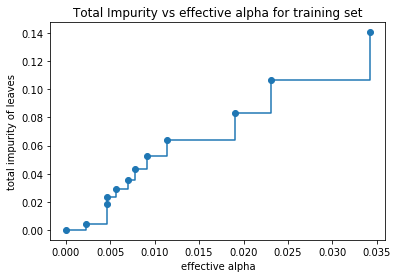

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post") # Removing the last pruning step where you only have the one-node tree left
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

During training, we do not want our whole tree to be pruned. So we need to define the ccp_alpha parameter correctly in order to stop pruning at the right time. Trees train very fast, so we can train multiple trees and test many values of ccp_alpha and plot how it affects accuracy. 

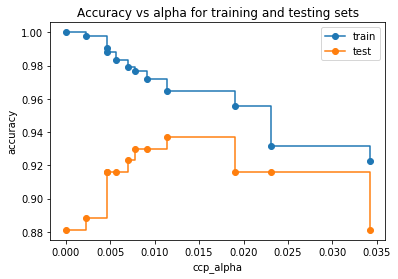

In [14]:
clfs = []

#training a tree for each value of ccp_alpha that we got in the path

ccp_alphas = ccp_alphas[:-1] #Removing once again the last tree that only contains the root

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

We can see on this plot the importance of pruning. With no pruning, our train set perfectly classifies the training set while only having 88% accuracy on the test set. 

The best value for ccp_alpha seems to be around 0.012. 

Source: scikit learn

## That's it ! 

Thank you for reading my notebook, I hope it was helpful and easy to understand ! It should be a nice addition to the class we had on decision trees 